### *Haremos un análisis a partir del csv que extrajimos de la API que tiene las columnas:*

+ artist_id 
+ track_id
+ artist_popularity
+ artist_followers

*No tenemos el nombre porque lo tenemos en spotify_dataset.csv y proximamente haremos con los datos de esta api y los datos de spotify_dataset*

In [1]:
import pandas as pd
import spotipy
import os
import time
import logging
from dotenv import load_dotenv
from tqdm import tqdm
from spotipy import SpotifyClientCredentials
from requests.exceptions import ReadTimeout, ConnectionError
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print(os.getcwd())

try:
    os.chdir("../../workshop_02")

except FileNotFoundError:
    print("Directory not found or already exists.")
    
print(os.getcwd())

/home/edwards/Documentos/university/etl/workshop_02/notebooks
/home/edwards/Documentos/university/etl/workshop_02


In [6]:
# Credenciales
SPOTIFY_CLIENT_ID = os.getenv("SPOTIFY_CLIENT_ID")
SPOTIFY_CLIENT_SECRET = os.getenv("SPOTIFY_CLIENT_SECRET")
url = "https://github.com/XGabrielEdwardsX/workshop_02"

In [ ]:
load_dotenv("env/.env")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

ORIGINAL_DATASET_PATH = "data/processed/spotify_dataset_cleaned.csv"
OUTPUT_CSV = "data/api_artist.csv"
TRACK_ID_COLUMN = "track_id"
BATCH_SIZE = 50
REQUEST_DELAY_SECONDS = 0.5

def setup_spotify_client():
    try:
        client_credentials_manager = SpotifyClientCredentials(
            client_id=os.getenv("SPOTIFY_CLIENT_ID"),
            client_secret=os.getenv("SPOTIFY_CLIENT_SECRET")
        )
        sp = spotipy.Spotify(
            client_credentials_manager=client_credentials_manager,
            requests_timeout=15,
            retries=5,
            status_retries=5,
            backoff_factor=0.3
        )
        sp.search(q='test', type='track', limit=1)
        logging.info("Spotify client configured and connection tested.")
        return sp
    except Exception:
        logging.error("Error setting up Spotify client. Check credentials in .env")
        raise

def extract_artist_info_per_track(sp_client, original_dataset_path, output_filepath, track_id_col):
    try:
        df_original_ids = pd.read_csv(original_dataset_path, usecols=[track_id_col])
        logging.info(f"Original file '{original_dataset_path}' read for IDs.")
    except FileNotFoundError:
        logging.error(f"File '{original_dataset_path}' not found.")
        return

    track_ids = df_original_ids[track_id_col].dropna().unique().tolist()
    logging.info(f"Processing {len(track_ids)} unique track IDs.")
    artist_data_results = []

    for i in tqdm(range(0, len(track_ids), BATCH_SIZE), desc="Processing Track Batches"):
        batch_track_ids = track_ids[i : i + BATCH_SIZE]
        try:
            time.sleep(REQUEST_DELAY_SECONDS)
            track_results = sp_client.tracks(batch_track_ids)
            artist_id_map_batch = {}
            artist_ids_to_fetch = set()

            if track_results and track_results['tracks']:
                for track_info in track_results['tracks']:
                    if track_info and track_info['id'] and track_info['artists']:
                        primary_artist = track_info['artists'][0]
                        if primary_artist and primary_artist['id']:
                            artist_id = primary_artist['id']
                            track_id = track_info['id']
                            artist_id_map_batch[track_id] = artist_id
                            artist_ids_to_fetch.add(artist_id)

            artist_details_map_batch = {}
            if artist_ids_to_fetch:
                unique_artist_ids_list = list(artist_ids_to_fetch)
                for j in range(0, len(unique_artist_ids_list), BATCH_SIZE):
                    sub_batch_artist_ids = unique_artist_ids_list[j : j + BATCH_SIZE]
                    time.sleep(REQUEST_DELAY_SECONDS)
                    artist_results = sp_client.artists(sub_batch_artist_ids)
                    if artist_results and artist_results['artists']:
                        for artist_info in artist_results['artists']:
                            if artist_info and artist_info['id']:
                                followers = artist_info.get('followers', {}).get('total', None)
                                popularity = artist_info.get('popularity', None)
                                artist_details_map_batch[artist_info['id']] = (followers, popularity)

            for original_track_id in batch_track_ids:
                artist_id = artist_id_map_batch.get(original_track_id)
                followers, popularity = None, None
                if artist_id:
                    followers, popularity = artist_details_map_batch.get(artist_id, (None, None))
                artist_data_results.append({
                    'track_id': original_track_id,
                    'artist_id': artist_id,
                    'artist_followers': followers,
                    'artist_popularity': popularity
                })

        except (spotipy.SpotifyException, ReadTimeout, ConnectionError):
            logging.warning(f"Error processing track batch {i}. Skipping.")
            time.sleep(5)

    if not artist_data_results:
        logging.warning("No results generated.")
        return

    df_final = pd.DataFrame(artist_data_results)
    logging.info(f"Processing completed. Total records: {len(df_final)}")
    output_dir = os.path.dirname(output_filepath)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    df_final.to_csv(output_filepath, index=False, encoding='utf-8')
    logging.info(f"Track-to-artist file saved at: '{output_filepath}'")

if __name__ == "__main__":
    logging.info("Starting track-to-artist extraction script...")
    start_time = time.time()
    sp = setup_spotify_client()
    if sp:
        extract_artist_info_per_track(sp, ORIGINAL_DATASET_PATH, OUTPUT_CSV, TRACK_ID_COLUMN)
    end_time = time.time()
    logging.info(f"Script finished. Total time: {end_time - start_time:.2f} seconds.")

2025-04-11 14:16:04,036 - INFO - Starting track-to-artist extraction script...
2025-04-11 14:16:04,701 - INFO - Spotify client configured and connection tested.
2025-04-11 14:16:04,947 - INFO - Original file 'data/processed/spotify_dataset_cleaned.csv' read for IDs.
2025-04-11 14:16:04,981 - INFO - Processing 89740 unique track IDs.
Processing Track Batches: 100%|██████████| 1795/1795 [45:24<00:00,  1.52s/it] 
2025-04-11 15:01:29,899 - INFO - Processing completed. Total records: 89740
2025-04-11 15:01:30,227 - INFO - Track-to-artist file saved at: 'data/api_artist.csv'
2025-04-11 15:01:30,309 - INFO - Script finished. Total time: 2726.27 seconds.


In [3]:
INPUT_CSV_PATH = "data/api_artist.csv"

print(f"Cargando datos desde: {INPUT_CSV_PATH}")
if not os.path.exists(INPUT_CSV_PATH):
    print(f"Error: El archivo no se encontró en la ruta: '{INPUT_CSV_PATH}'")
else:
    try:
        df = pd.read_csv(INPUT_CSV_PATH)
        print("Datos cargados exitosamente.")
    except Exception as e:
        print(f"Error al cargar el archivo CSV: {e}")

Cargando datos desde: data/api_artist.csv
Datos cargados exitosamente.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89740 entries, 0 to 89739
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   track_id           89740 non-null  object
 1   artist_id          89740 non-null  object
 2   artist_followers   89740 non-null  int64 
 3   artist_popularity  89740 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.7+ MB


Vemos que tenemos un dato con int64, lo cambiaremos a int32 para que python los tome con mas facilidad

In [6]:
# Convert int64 columns to int32
df['artist_followers'] = df['artist_followers'].astype('int32')
df['artist_popularity'] = df['artist_popularity'].astype('int32')

In [35]:
df.describe()

,artist_followers,artist_popularity
count,89740,89740
mean,2999397,52
std,10178879,19
min,0,0
25%,39885,41
50%,239021,54
75%,1397570,66
max,142371108,100


visualizamos los datos para tener mejor comprensión de lo que estamos haciendo

In [36]:
df.head()

,track_id,artist_id,artist_followers,artist_popularity
0,5SuOikwiRyPMVoIQDJUgSV,1S2S00lgLYLGHWA44qGEUs,2096701,65
1,4qPNDBW1i3p13qLCt0Ki3A,142VT1MtWzaD13CnOiKFDn,22524,44
2,1iJBSr7s7jYXzM8EGcbK5b,2vm8GdHyrJh2O2MfbQFYG0,803297,57
3,6lfxq3CG4xtTiEg7opyCyx,7h4j9YTJJuAHzLCc3KCvYu,521097,61
4,5vjLSffimiIP26QG5WcN2K,5D3muNJhYYunbRkh3FKgX0,348149,64


Si revisamos *spotify_dataset_cleaned.csv* vemos que coinciden los datos de las primeras 5 columnas

In [13]:
df.isnull().sum()

track_id             0
artist_id            0
artist_followers     0
artist_popularity    0
dtype: int64

No existen valores nulos debido a que como los datos fueron traidos a partir de **track_id** y esta columna no era nula, pudo encontrar todos los valores que coincidan con ella. En este caso los encontro todos gracias a la api de spotify y a spotify_dataset_cleaned.csv

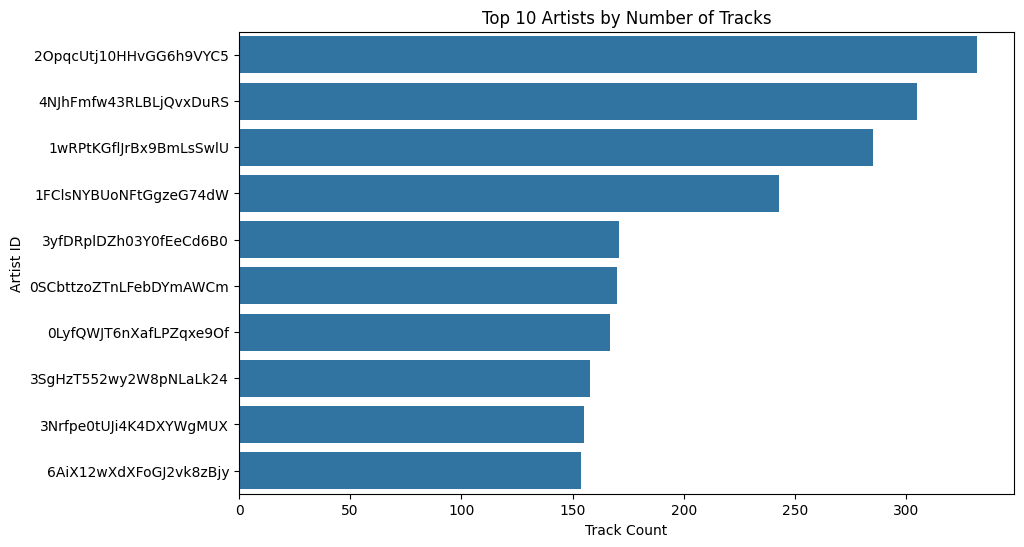

Top 10 artists by number of tracks:
                artist_id  track_count
0  2OpqcUtj10HHvGG6h9VYC5          332
1  4NJhFmfw43RLBLjQvxDuRS          305
2  1wRPtKGflJrBx9BmLsSwlU          285
3  1FClsNYBUoNFtGgzeG74dW          243
4  3yfDRplDZh03Y0fEeCd6B0          171
5  0SCbttzoZTnLFebDYmAWCm          170
6  0LyfQWJT6nXafLPZqxe9Of          167
7  3SgHzT552wy2W8pNLaLk24          158
8  3Nrfpe0tUJi4K4DXYWgMUX          155
9  6AiX12wXdXFoGJ2vk8zBjy          154


In [37]:
top_tracks = df.groupby('artist_id')['track_id'].count().sort_values(ascending=False).head(10).reset_index(name='track_count')

plt.figure(figsize=(10, 6))
sns.barplot(data=top_tracks, x='track_count', y='artist_id')
plt.title('Top 10 Artists by Number of Tracks')
plt.xlabel('Track Count')
plt.ylabel('Artist ID')
plt.show()

print("Top 10 artists by number of tracks:")
print(top_tracks[['artist_id', 'track_count']])

Como no tenemos el nombre la información que manejamos es a partir de id, en esto caso buscamos al artista con más canciones. Si buscamos el primer id que es el artista con **332** canciones vemos que es **George Jones**

In [20]:
most_followers = df[['artist_id', 'artist_followers']].drop_duplicates().sort_values(by='artist_followers', ascending=False)
print("Artist with most followers:")
print(most_followers)

Artist with most followers:
                    artist_id  artist_followers
48408  4YRxDV8wJFPHPTeXepOstw         142371108
67647  06HL4z0CvFAxyc27GXpf02         135524083
57112  6eUKZXaKkcviH0Ku9w2n3V         119952016
28406  6qqNVTkY8uBg9cP3Jd7DAH         110148270
18914  66CXWjxzNUsdJxJ2JdwvnR         104776597
...                       ...               ...
74311  1XHA9Qzs1CLJK2VSiQ767a                 0
13075  3xamqYiPRxSOxMNbMxfx2g                 0
75053  3DslmJXEfwYhBcB9s6fb9C                 0
88734  1cYv8XzxDOcqpKMosysFra                 0
55892  1rFinGawCuuPCk4JrVZemf                 0

[17847 rows x 2 columns]


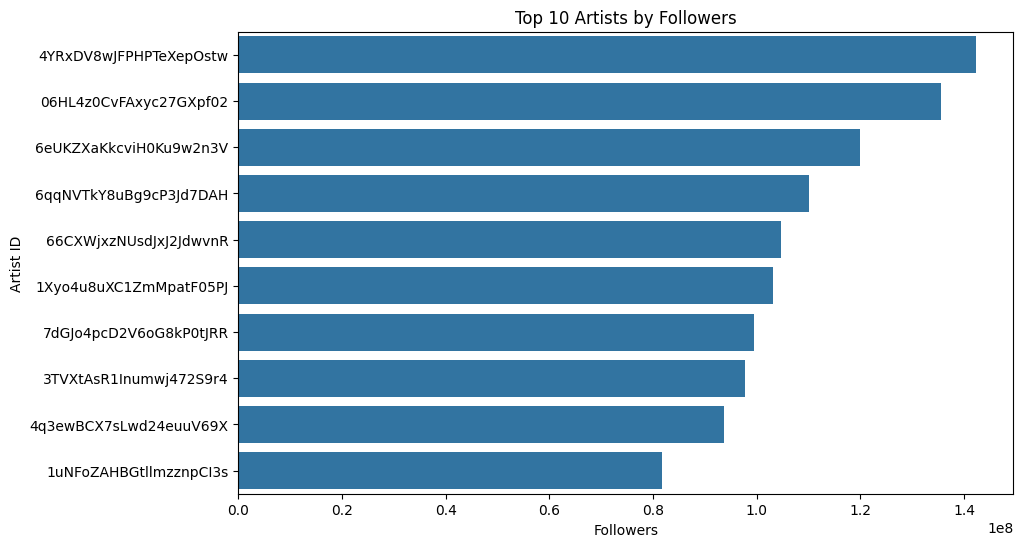

Top 10 artists by followers:
                    artist_id  artist_followers
48408  4YRxDV8wJFPHPTeXepOstw         142371108
67647  06HL4z0CvFAxyc27GXpf02         135524083
57112  6eUKZXaKkcviH0Ku9w2n3V         119952016
28406  6qqNVTkY8uBg9cP3Jd7DAH         110148270
18914  66CXWjxzNUsdJxJ2JdwvnR         104776597
67617  1Xyo4u8uXC1ZmMpatF05PJ         103059943
45335  7dGJo4pcD2V6oG8kP0tJRR          99472724
45283  3TVXtAsR1Inumwj472S9r4          97670260
19462  4q3ewBCX7sLwd24euuV69X          93750852
19871  1uNFoZAHBGtllmzznpCI3s          81770719


In [39]:
top_followers = df[['artist_id', 'artist_followers']].drop_duplicates().sort_values(by='artist_followers', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_followers, x='artist_followers', y='artist_id')
plt.title('Top 10 Artists by Followers')
plt.xlabel('Followers')
plt.ylabel('Artist ID')
plt.show()

print("Top 10 artists by followers:")
print(top_followers[['artist_id', 'artist_followers']])

En este caso queremos saber cual es el artista con más seguidores y si buscamos el id en internet es: **Arijit Singh**

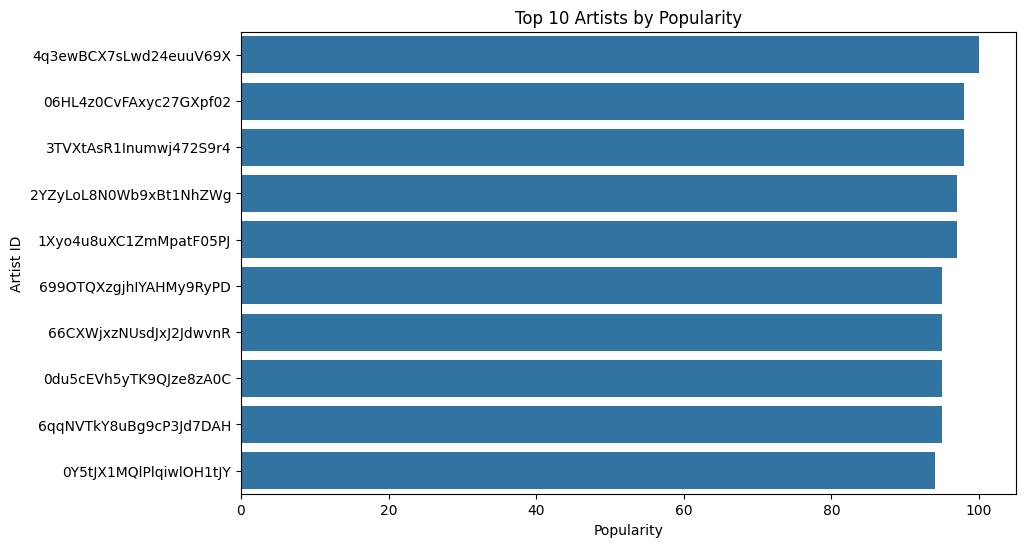

Top 10 artists by popularity:
                    artist_id  artist_popularity
19462  4q3ewBCX7sLwd24euuV69X                100
67647  06HL4z0CvFAxyc27GXpf02                 98
45283  3TVXtAsR1Inumwj472S9r4                 98
45519  2YZyLoL8N0Wb9xBt1NhZWg                 97
67617  1Xyo4u8uXC1ZmMpatF05PJ                 97
45683  699OTQXzgjhIYAHMy9RyPD                 95
18914  66CXWjxzNUsdJxJ2JdwvnR                 95
18966  0du5cEVh5yTK9QJze8zA0C                 95
28406  6qqNVTkY8uBg9cP3Jd7DAH                 95
45472  0Y5tJX1MQlPlqiwlOH1tJY                 94


In [38]:
top_popularity = df[['artist_id', 'artist_popularity']].drop_duplicates().sort_values(by='artist_popularity', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_popularity, x='artist_popularity', y='artist_id')
plt.title('Top 10 Artists by Popularity')
plt.xlabel('Popularity')
plt.ylabel('Artist ID')
plt.show()

print("Top 10 artists by popularity:")
print(top_popularity[['artist_id', 'artist_popularity']])

Y algo que es de esperar, es que el artista con más popularidad es **Bad Bunny**

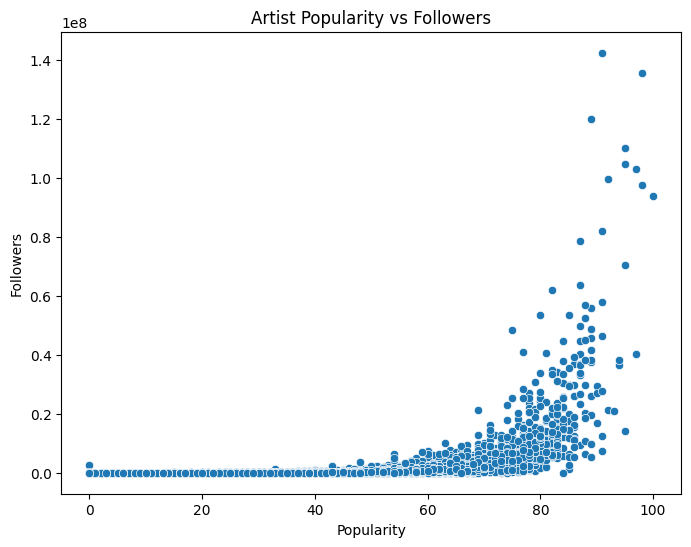

To find artists in scatter plot, check artist_id with high/low popularity and followers:
                    artist_id  artist_popularity  artist_followers
19462  4q3ewBCX7sLwd24euuV69X                100          93750852
67647  06HL4z0CvFAxyc27GXpf02                 98         135524083
45283  3TVXtAsR1Inumwj472S9r4                 98          97670260
67617  1Xyo4u8uXC1ZmMpatF05PJ                 97         103059943
45519  2YZyLoL8N0Wb9xBt1NhZWg                 97          40123018


In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df.drop_duplicates('artist_id'), x='artist_popularity', y='artist_followers')
plt.title('Artist Popularity vs Followers')
plt.xlabel('Popularity')
plt.ylabel('Followers')
plt.show()

print("To find artists in scatter plot, check artist_id with high/low popularity and followers:")
print(df.drop_duplicates('artist_id')[['artist_id', 'artist_popularity', 'artist_followers']].sort_values(by=['artist_popularity', 'artist_followers'], ascending=False).head(5))

Aquí hacemos unos análisis entre la popularidad y los seguidores y vemos que a si hay una relación bastante notable entre la popularidad y el número de seguidores y vemos que a mayor popularidad mayor número de seguidores exceptuando por algunos artistas con mas de 90 de popularidad y menor seguidores que algunos con 80 puntos de popularidad

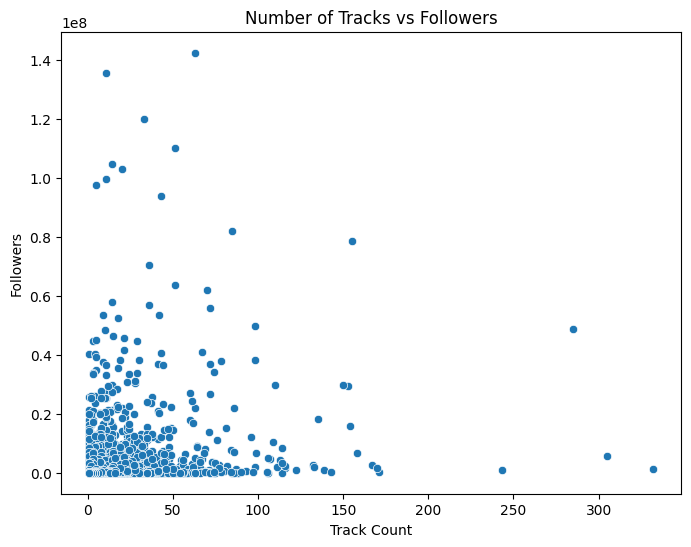

In [24]:
artist_track_counts = df.groupby('artist_id')['track_id'].count().reset_index(name='track_count')
artist_data = df.drop_duplicates('artist_id')[['artist_id', 'artist_followers']].merge(artist_track_counts, on='artist_id')

plt.figure(figsize=(8, 6))
sns.scatterplot(data=artist_data, x='track_count', y='artist_followers')
plt.title('Number of Tracks vs Followers')
plt.xlabel('Track Count')
plt.ylabel('Followers')
plt.show()

Algo interesante en esta parte es que pasa algo muy diferente al gráfico anterior, y esta tiene que ver con la cantidad de canciones de los artistas y lo resumiré de la siguiente manera. "Es mejor 10 canciones buenas que 100 canciones malas", ya que a menor o a número intermedio de canciones mayor número de seguidores.

In [9]:
object_cols = df.select_dtypes(include=['object']).columns
for col in object_cols:
    df[col] = df[col].str.lower().str.strip()

In [13]:
df['artist_followers'] = df['artist_followers'].astype('int32')
df['artist_popularity'] = df['artist_popularity'].astype('int32')

object_cols = df.select_dtypes(include=['object']).columns
for col in object_cols:
    df[col] = df[col].str.lower().str.strip()

output_path = 'data/api_artist.csv'
output_dir = os.path.dirname(output_path)

if output_dir and not os.path.exists(output_dir):
    os.makedirs(output_dir)

df.to_csv(output_path, index=False)

In [11]:
df.to_csv('data/api.csv', index=False)

Lo último que haremos será la normalización de las columnas para evitar errores a la hora de hacer el merge final

In [7]:
df.head()

,track_id,artist_id,artist_followers,artist_popularity
0,5suoikwirypmvoiqdjugsv,1s2s00lglylghwa44qgeus,2096701,65
1,4qpndbw1i3p13qlct0ki3a,142vt1mtwzad13cnoikfdn,22524,44
2,1ijbsr7s7jyxzm8egcbk5b,2vm8gdhyrjh2o2mfbqfyg0,803297,57
3,6lfxq3cg4xttieg7opycyx,7h4j9ytjjuahzlcc3kcvyu,521097,61
4,5vjlsffimiip26qg5wcn2k,5d3munjhyyunbrkh3fkgx0,348149,64


Hasta aquí el análisis. Y la única transformación que se hizo fue un cambio en el tipo de datos en followers y popularity